<a href="https://colab.research.google.com/github/OJB-Quantum/Onri-Bezier-Approximation/blob/main/TMR_Loops_and_Stoner_Wohlfarth%2BOBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

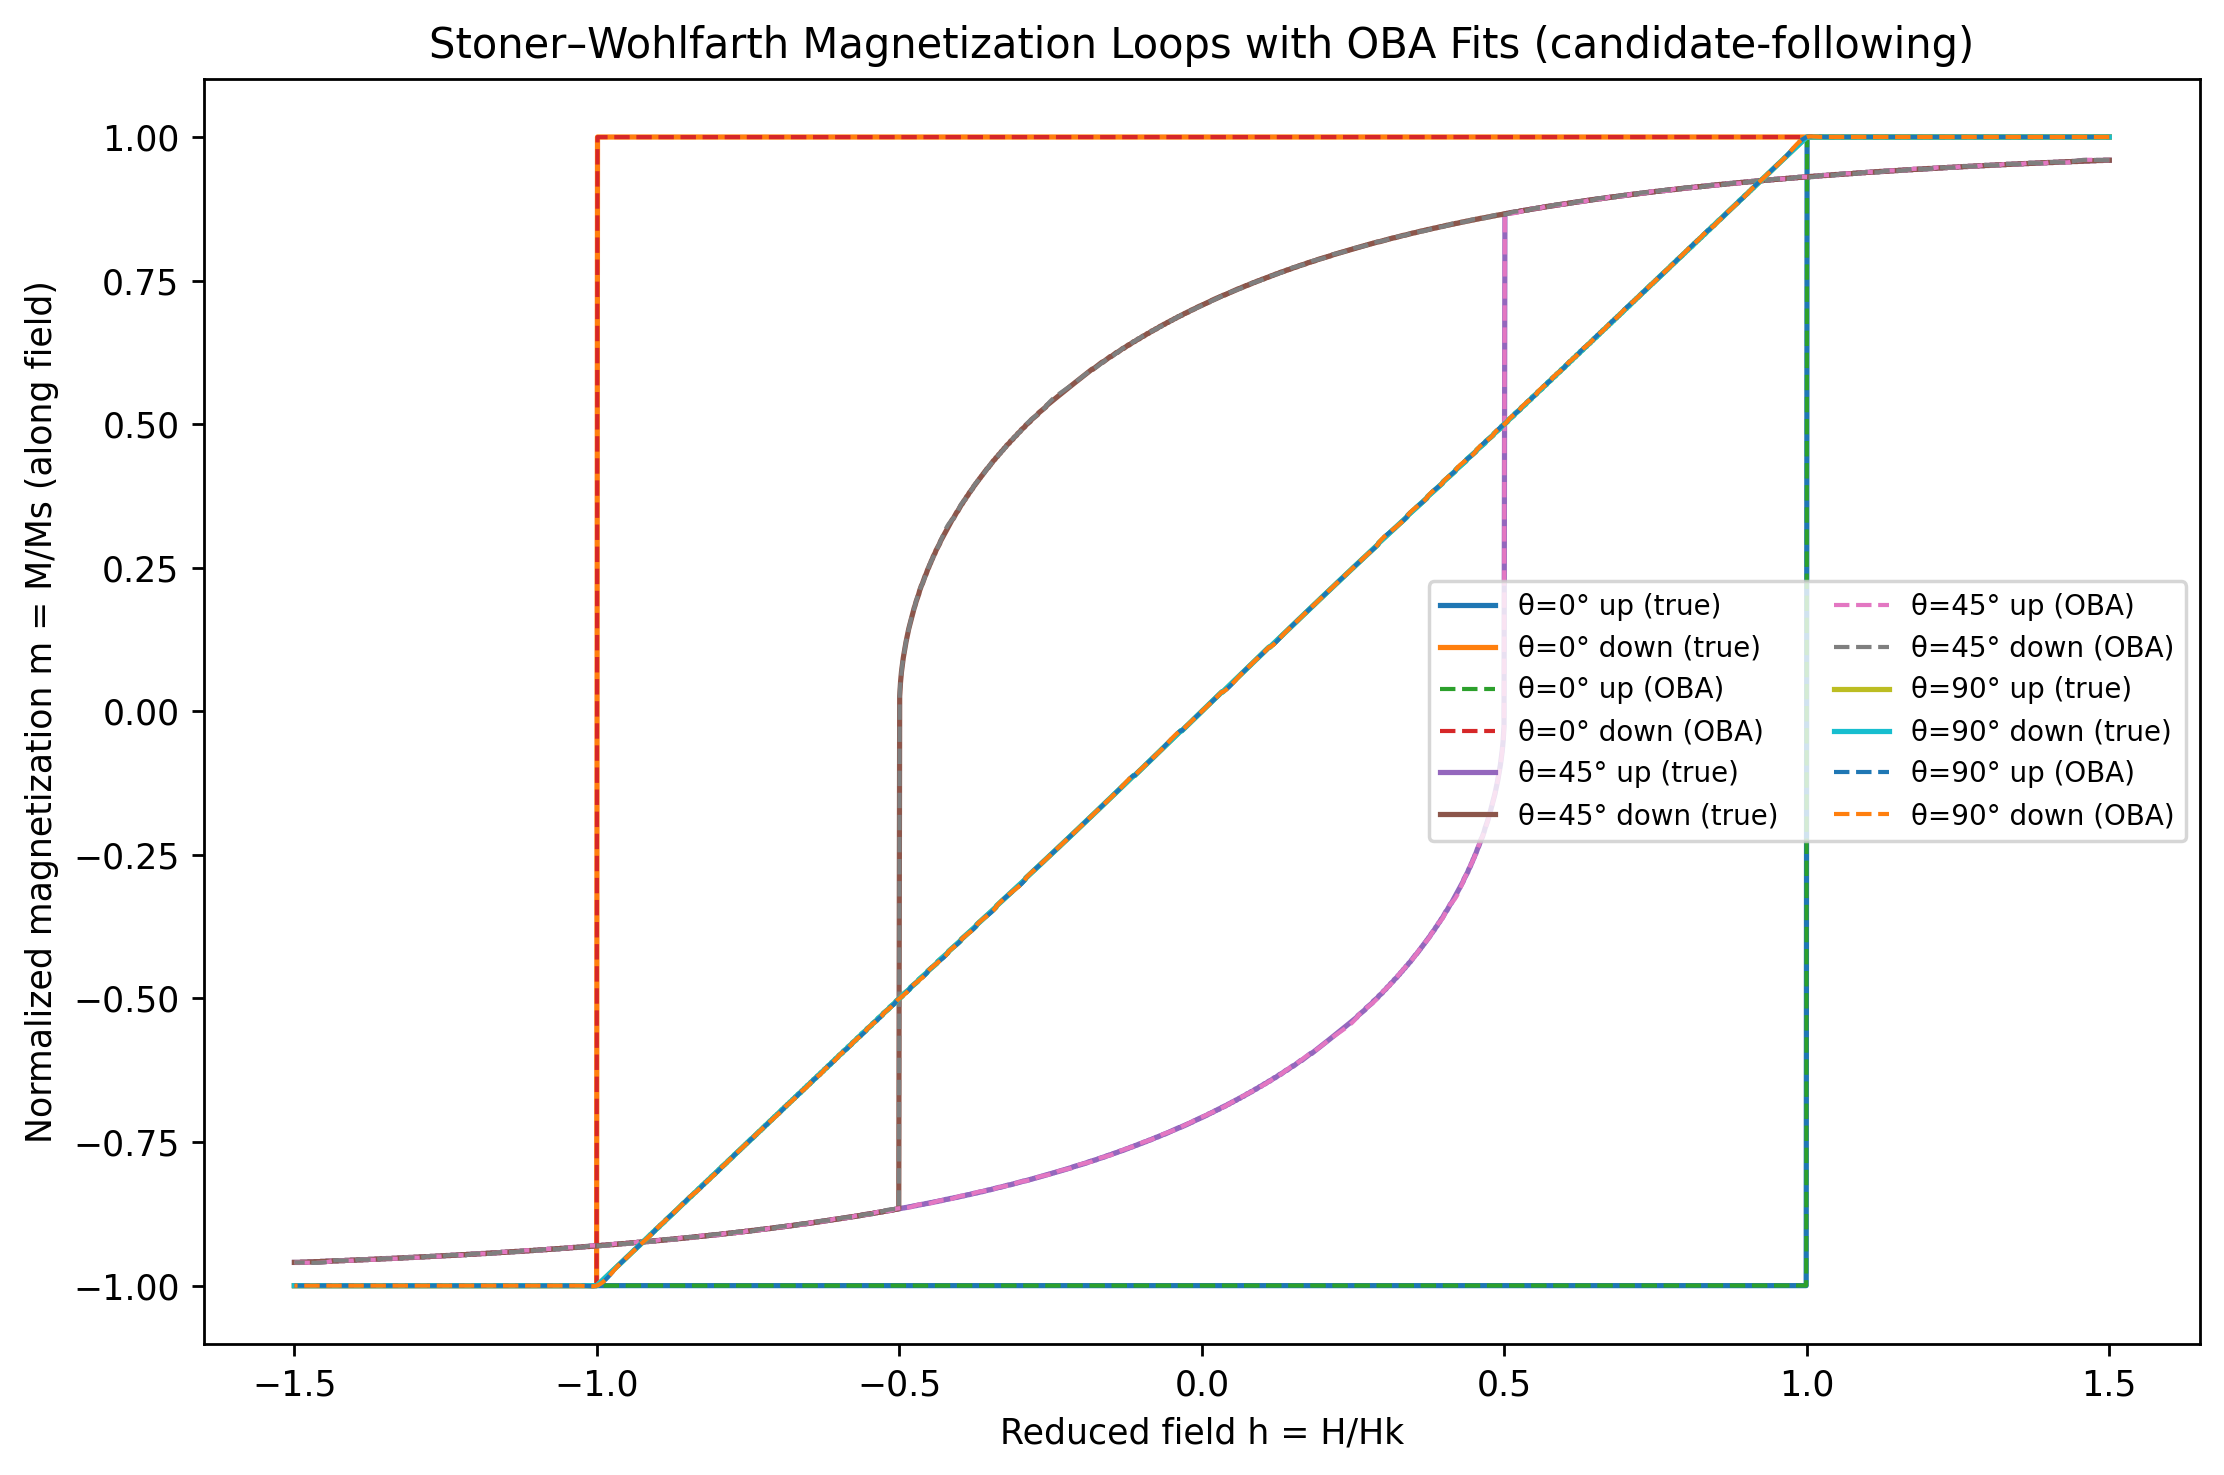

In [16]:
# Stoner–Wohlfarth magnetization loops (θ = 0°, 45°, 90°)
# OBA composite Bézier fit that follows a dense, shape-preserving candidate sweep.
#
# Plots: m(h) true vs. OBA (candidate-derivative tangents, two-pass anchor clustering)

import math
import os
from typing import Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt

try:
    import nbformat as nbf
except Exception:
    nbf = None

plt.rcParams["figure.dpi"] = 250

# ------------------------------
# 0) User controls (OBA knobs)
# ------------------------------
CLUSTER_PERCENTILE: float = 30.0     # 0–100; higher → anchors concentrate only at sharpest bends
TANGENT_SOURCE: str = "candidate"    # "candidate" | "monotone" | "centripetal"
CANDIDATE_OVERSAMPLE: int = 24       # 12–80 typical; increases density of the candidate sweep
MAX_ANCHORS_PER_BRANCH: int = 400    # protective cap per branch
DENSIFY_ITERS: int = 28              # # of curvature-mass insertions
DENSIFY_TOP_FRAC: float = 0.95       # ≥ this fraction of anchors end up in top-5% curvature
PACKING_SCALE: float = 0.25          # scales the local exclusion radius (smaller → more anchors)
NUM_SEG_MIN, NUM_SEG_MAX = 260, 360  # Bézier samples per span (auto-chosen from percentile)

# NumPy 2.0 deprecation shim (trapz → trapezoid) for curvature-mass integration
try:
    _trapz = np.trapezoid
except AttributeError:
    _trapz = np.trapz

# ------------------------------
# 1) Stoner–Wohlfarth simulator
# ------------------------------
def _angle_wrap(a: np.ndarray) -> np.ndarray:
    """Wrap angle to (-pi, pi]."""
    return (a + np.pi) % (2 * np.pi) - np.pi

def _local_minima(y: np.ndarray) -> np.ndarray:
    """Indices where y[i] is a strict local minimum (with periodic boundary)."""
    if y.size < 3:
        return np.array([np.argmin(y)])
    y_ext = np.r_[y[-1], y, y[0]]
    mins = np.where((y_ext[1:-1] < y_ext[:-2]) & (y_ext[1:-1] < y_ext[2:]))[0]
    return mins.astype(int)

def _nearest_angle(phi_candidates: np.ndarray, phi_prev: float) -> float:
    """Choose candidate angle nearest to previous angle (circular distance)."""
    if phi_candidates.size == 0:
        return float(phi_prev)
    diffs = np.abs(_angle_wrap(phi_candidates - phi_prev))
    return float(phi_candidates[np.argmin(diffs)])

def sw_energy(phi: np.ndarray, h: float, theta: float) -> np.ndarray:
    """
    Dimensionless SW energy (per 2Ku): e(φ) = 0.5 * sin^2(φ - θ) - h * cos(φ)
    φ: magnetization angle wrt field axis
    θ: easy-axis angle wrt field axis
    h: reduced field H/H_k
    """
    return 0.5 * np.sin(phi - theta) ** 2 - h * np.cos(phi)

def sw_sweep(theta_deg: float,
             h_min: float = -1.5, h_max: float = 1.5, n_h: int = 2001,
             n_phi: int = 4096) -> Dict[str, np.ndarray]:
    """
    Compute up- and down-sweep SW magnetization for a given θ (degrees).
    Returns: h_up, m_up, phi_up, h_dn, m_dn, phi_dn, theta_deg.
    """
    theta = math.radians(theta_deg)
    h_up = np.linspace(h_min, h_max, int(n_h))
    h_dn = np.linspace(h_max, h_min, int(n_h))
    phi_grid = np.linspace(-np.pi, np.pi, int(n_phi), endpoint=False)

    def do_sweep(h_grid: np.ndarray, init_from_global_min: bool) -> Tuple[np.ndarray, np.ndarray]:
        phis = np.zeros_like(h_grid)
        phi_prev = None
        for i, h in enumerate(h_grid):
            e = sw_energy(phi_grid, float(h), theta)
            idx_minima = _local_minima(e)
            phi_candidates = phi_grid[idx_minima]
            if i == 0 and init_from_global_min:
                j = int(np.argmin(e))
                if j not in idx_minima and idx_minima.size > 0:
                    j = int(idx_minima[np.argmin(np.abs(idx_minima - j))])
                phi_prev = float(phi_grid[j])
                phis[i] = phi_prev
                continue
            if phi_prev is None:
                phi_prev = 0.0 if phi_candidates.size == 0 else float(phi_candidates[np.argmin(np.abs(phi_candidates))])
            phi_now = _nearest_angle(phi_candidates, phi_prev)
            phis[i] = phi_now
            phi_prev = phi_now
        m = np.cos(phis)  # projection along field axis
        return phis, m

    phi_up, m_up = do_sweep(h_up, init_from_global_min=True)
    phi_dn, m_dn = do_sweep(h_dn, init_from_global_min=True)

    return {
        "h_up": h_up, "m_up": m_up, "phi_up": phi_up,
        "h_dn": h_dn, "m_dn": m_dn, "phi_dn": phi_dn,
        "theta_deg": theta_deg
    }

# ------------------------------------
# 2) OBA composite Bézier (candidate-following)
#     Two-pass curvature clustering + candidate-derivative tangents
# ------------------------------------
def _smooth_1d(z: np.ndarray, win: int) -> np.ndarray:
    if win <= 1:
        return z.copy()
    k = np.ones(int(win), float) / float(win)
    pad = int(win) // 2
    zp = np.pad(z, (pad, pad), mode="reflect")
    return np.convolve(zp, k, mode="valid")

def _parametric_curvature(sv: np.ndarray, xv: np.ndarray, yv: np.ndarray) -> np.ndarray:
    x_s = np.gradient(xv, sv, edge_order=1)
    y_s = np.gradient(yv, sv, edge_order=1)
    x_ss = np.gradient(x_s, sv, edge_order=1)
    y_ss = np.gradient(y_s, sv, edge_order=1)
    num = np.abs(x_s * y_ss - y_s * x_ss)
    den = (x_s ** 2 + y_s ** 2) ** 1.5 + 1e-12
    return num / den

def _hermite_to_bezier(Pi: np.ndarray, Ti: np.ndarray,
                       Pj: np.ndarray, Tj: np.ndarray,
                       si: float, sj: float, m: int) -> np.ndarray:
    h = sj - si
    c0, c3 = Pi, Pj
    c1 = Pi + (Ti * h / 3.0)
    c2 = Pj - (Tj * h / 3.0)
    t = np.linspace(0.0, 1.0, int(m))
    b = ((1 - t)[:, None] ** 3) * c0 + (3 * (1 - t)[:, None] ** 2 * t[:, None]) * c1 \
        + (3 * (1 - t)[:, None] * t[:, None] ** 2) * c2 + (t[:, None] ** 3) * c3
    return b

# --- candidate curve (monotone H, PCHIP-like for y) ---
def _pchip_slopes(s: np.ndarray, y: np.ndarray) -> np.ndarray:
    s = np.asarray(s, float); y = np.asarray(y, float)
    n = len(s)
    m = np.zeros(n, float)
    ds = np.diff(s); dy = np.diff(y)
    d = dy / ds
    m[0] = d[0]; m[-1] = d[-1]
    for i in range(1, n-1):
        if d[i-1] * d[i] <= 0:
            m[i] = 0.0
        else:
            w1 = 2*ds[i] + ds[i-1]
            w2 = ds[i] + 2*ds[i-1]
            m[i] = (w1 + w2) / (w1/d[i-1] + w2/d[i])
    return m

def _pchip_eval(s: np.ndarray, y: np.ndarray, m: np.ndarray, s_eval: np.ndarray) -> np.ndarray:
    s = np.asarray(s, float); y = np.asarray(y, float); m = np.asarray(m, float)
    s_eval = np.asarray(s_eval, float)
    idx = np.searchsorted(s, s_eval, side="right") - 1
    idx = np.clip(idx, 0, len(s)-2)
    s0 = s[idx]; s1 = s[idx+1]
    y0 = y[idx]; y1 = y[idx+1]
    m0 = m[idx]; m1 = m[idx+1]
    h = (s_eval - s0) / (s1 - s0 + 1e-15)
    h2 = h*h; h3 = h2*h
    H00 = 2*h3 - 3*h2 + 1
    H10 = h3 - 2*h2 + h
    H01 = -2*h3 + 3*h2
    H11 = h3 - h2
    return H00*y0 + H10*(s1 - s0)*m0 + H01*y1 + H11*(s1 - s0)*m1

def _dense_candidate_curve(x: np.ndarray, y: np.ndarray, oversample: int = 24):
    x = np.asarray(x, float); y = np.asarray(y, float)
    dx, dy = np.diff(x), np.diff(y); ds = np.hypot(dx, dy)
    s = np.concatenate([[0.0], np.cumsum(ds)])
    s = np.linspace(0, 1, len(x)) if (s[-1] == 0) else (s / s[-1])
    n = len(s)
    n_f = max(8*n, int(len(s) * max(4, int(oversample))))
    s_f = np.linspace(0.0, 1.0, int(n_f))
    x_f = np.interp(s_f, s, x)               # monotone H
    m = _pchip_slopes(s, y)
    y_f = _pchip_eval(s, y, m, s_f)          # smooth y(H)
    return s_f, x_f, y_f

def _tangents_from_candidate(s_f: np.ndarray, x_f: np.ndarray, y_f: np.ndarray, keep_idx: np.ndarray) -> np.ndarray:
    dx_ds = np.gradient(x_f, s_f, edge_order=1)
    dy_ds = np.gradient(y_f, s_f, edge_order=1)
    return np.stack([dx_ds[keep_idx], dy_ds[keep_idx]], axis=1)

def _tangents_centripetal(P: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    n = len(P)
    T = np.zeros_like(P, float)
    t = np.zeros(n, float)
    for i in range(1, n):
        t[i] = t[i-1] + np.linalg.norm(P[i] - P[i-1])**alpha
    for i in range(n):
        if i == 0:
            dt = t[1] - t[0] if t[1] > t[0] else 1.0
            T[i] = (P[1] - P[0]) / dt
        elif i == n - 1:
            dt = t[-1] - t[-2] if t[-1] > t[-2] else 1.0
            T[i] = (P[-1] - P[-2]) / dt
        else:
            dt = t[i+1] - t[i-1] if t[i+1] > t[i-1] else 1.0
            T[i] = (P[i+1] - P[i-1]) / dt
    return T

def _tangents_monotone(x: np.ndarray, y: np.ndarray, s_a: np.ndarray) -> np.ndarray:
    n = len(x)
    m = np.zeros(n, float)
    dx = np.diff(x); dy = np.diff(y)
    d = dy / dx
    m[0] = d[0]; m[-1] = d[-1]
    for i in range(1, n-1):
        if d[i-1] * d[i] <= 0:
            m[i] = 0.0
        else:
            w1 = 2*dx[i] + dx[i-1]
            w2 = dx[i] + 2*dx[i-1]
            m[i] = (w1 + w2) / (w1/d[i-1] + w2/d[i])
    ds_dx = np.gradient(s_a, x, edge_order=1)
    return np.stack([ds_dx, m*ds_dx], axis=1)

def _map_percentile_to_hparams(p: float):
    a = float(np.clip(p, 0.0, 100.0)) / 100.0
    return dict(
        r_base=float(np.interp(a, [0, 1], [0.01, 0.08])),
        r_min_floor=float(np.interp(a, [0, 1], [1e-7, 5e-7])),
        r_shrink_max=float(np.interp(a, [0, 1], [0.97, 0.999])),
        r_power=float(np.interp(a, [0, 1], [4.0, 8.0])),
        smooth_window=int(round(np.interp(a, [0, 1], [7, 13]))),
        num_seg_per_bezier=int(round(np.interp(a, [0, 1], [NUM_SEG_MIN, NUM_SEG_MAX]))),
    )

def oba_fit_branch_follow(
    x: np.ndarray, y: np.ndarray,
    cluster_percentile: float = 30.0,
    tangent_source: str = "candidate",
    oversample: int = 24,
    max_anchors: int = 400,
    densify_iters: int = 28,
    densify_top_frac: float = 0.95,
    packing_scale: float = 0.25,
):
    # Dense candidate curve, independent of raw sampling
    s_f, x_f, y_f = _dense_candidate_curve(x, y, oversample=oversample)
    hp = _map_percentile_to_hparams(cluster_percentile)

    # Curvature & weight on dense curve
    kappa = _smooth_1d(_parametric_curvature(s_f, x_f, y_f), hp["smooth_window"])
    kappa = np.maximum(kappa, 0.0)
    thr = np.percentile(kappa, float(cluster_percentile))
    kmax = float(kappa.max()) if kappa.size else 1.0
    w = np.clip((kappa - thr) / (kmax - thr + 1e-15), 0.0, 1.0)

    # Pass 1: variable-radius greedy (with packing scale)
    r_local = hp["r_base"] * (1.0 - hp["r_shrink_max"] * (w ** hp["r_power"]))
    r_local = np.maximum(r_local, hp["r_min_floor"]) * float(max(1e-6, packing_scale))
    order = np.argsort(-w).astype(int)
    order = order[(order >= 0) & (order < len(s_f))]
    keep = [0, len(s_f)-1]
    kept = np.zeros(len(s_f), bool); kept[0] = kept[-1] = True

    def _too_close(i: int) -> bool:
        for j in np.where(kept)[0]:
            if abs(s_f[i] - s_f[j]) < min(r_local[i], r_local[j]):
                return True
        return False

    for i in order:
        if kept[i]:
            continue
        if not _too_close(i):
            keep.append(i); kept[i] = True
        if len(keep) >= max_anchors:
            break
    keep.sort()
    keep = np.array(keep, int)

    # Pass 2: densify in highest curvature-mass gaps
    target_top = int(densify_top_frac * len(keep))
    for _ in range(int(densify_iters)):
        thr95 = np.percentile(kappa, 95.0)
        n_top = np.count_nonzero(kappa[keep] >= thr95)
        if n_top >= target_top or len(keep) >= max_anchors:
            break
        best_gain = 0.0; best_pos = None; best_insert = None
        for a_idx in range(len(keep)-1):
            i, j = keep[a_idx], keep[a_idx+1]
            if j <= i + 1:
                continue
            window = slice(i+1, j)
            mass = _trapz(w[window], s_f[window])
            if mass > best_gain:
                loc = int(np.argmax(kappa[window])) + (i+1)
                best_gain = mass; best_pos = loc; best_insert = a_idx + 1
        if best_pos is None:
            break
        pos = int(best_pos)
        if pos < 0 or pos >= len(s_f):
            continue
        if not _too_close(pos):
            keep = np.insert(keep, best_insert, pos)

    # Anchors from dense curve
    s_a = s_f[keep]
    P_a = np.stack([x_f[keep], y_f[keep]], axis=1)

    # Tangents: candidate derivatives or alternatives
    if tangent_source == "candidate":
        T = _tangents_from_candidate(s_f, x_f, y_f, keep)
    elif tangent_source == "monotone":
        T = _tangents_monotone(P_a[:,0], P_a[:,1], s_a)
    else:
        T = _tangents_centripetal(P_a, alpha=0.5)

    # Build composite Bézier from anchors
    seg_pts = []
    for i in range(len(s_a)-1):
        seg = _hermite_to_bezier(P_a[i], T[i], P_a[i+1], T[i+1],
                                 s_a[i], s_a[i+1], hp["num_seg_per_bezier"])
        if i > 0:
            seg = seg[1:]  # avoid duplicate joints
        seg_pts.append(seg)
    seg_pts = np.vstack(seg_pts) if seg_pts else P_a.copy()
    return seg_pts[:, 0], seg_pts[:, 1], P_a, keep, kappa, s_f, hp

# ------------------------------
# 3) Generate curves & fit OBA (magnetization only)
# ------------------------------
H_MIN, H_MAX, N_H = -1.5, 1.5, 2001
ORIENTATIONS = [0.0, 45.0, 90.0]   # degrees

results: List[Dict[str, np.ndarray]] = []
for th in ORIENTATIONS:
    sim = sw_sweep(th, H_MIN, H_MAX, N_H, 4096)

    # OBA fits per monotone branch
    bx_up_m, by_up_m, *_ = oba_fit_branch_follow(
        sim["h_up"], sim["m_up"],
        cluster_percentile=CLUSTER_PERCENTILE,
        tangent_source=TANGENT_SOURCE,
        oversample=CANDIDATE_OVERSAMPLE,
        max_anchors=MAX_ANCHORS_PER_BRANCH,
        densify_iters=DENSIFY_ITERS,
        densify_top_frac=DENSIFY_TOP_FRAC,
        packing_scale=PACKING_SCALE,
    )
    bx_dn_m, by_dn_m, *_ = oba_fit_branch_follow(
        sim["h_dn"], sim["m_dn"],
        cluster_percentile=CLUSTER_PERCENTILE,
        tangent_source=TANGENT_SOURCE,
        oversample=CANDIDATE_OVERSAMPLE,
        max_anchors=MAX_ANCHORS_PER_BRANCH,
        densify_iters=DENSIFY_ITERS,
        densify_top_frac=DENSIFY_TOP_FRAC,
        packing_scale=PACKING_SCALE,
    )

    sim["oba_m_up"] = (bx_up_m, by_up_m)
    sim["oba_m_dn"] = (bx_dn_m, by_dn_m)
    results.append(sim)

# ------------------------------
# 4) Plot: Magnetization loops (true vs OBA)
# ------------------------------
plt.figure(figsize=(9, 6))
for sim in results:
    th = sim["theta_deg"]
    # True branches
    plt.plot(sim["h_up"], sim["m_up"], linewidth=1.5, label=f"θ={th:.0f}° up (true)")
    plt.plot(sim["h_dn"], sim["m_dn"], linewidth=1.5, label=f"θ={th:.0f}° down (true)")
    # OBA branches (dashed)
    bx, by = sim["oba_m_up"]
    plt.plot(bx, by, linestyle="--", linewidth=1.2, label=f"θ={th:.0f}° up (OBA)")
    bx, by = sim["oba_m_dn"]
    plt.plot(bx, by, linestyle="--", linewidth=1.2, label=f"θ={th:.0f}° down (OBA)")

plt.xlabel("Reduced field h = H/Hk")
plt.ylabel("Normalized magnetization m = M/Ms (along field)")
plt.title("Stoner–Wohlfarth Magnetization Loops with OBA Fits (candidate-following)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

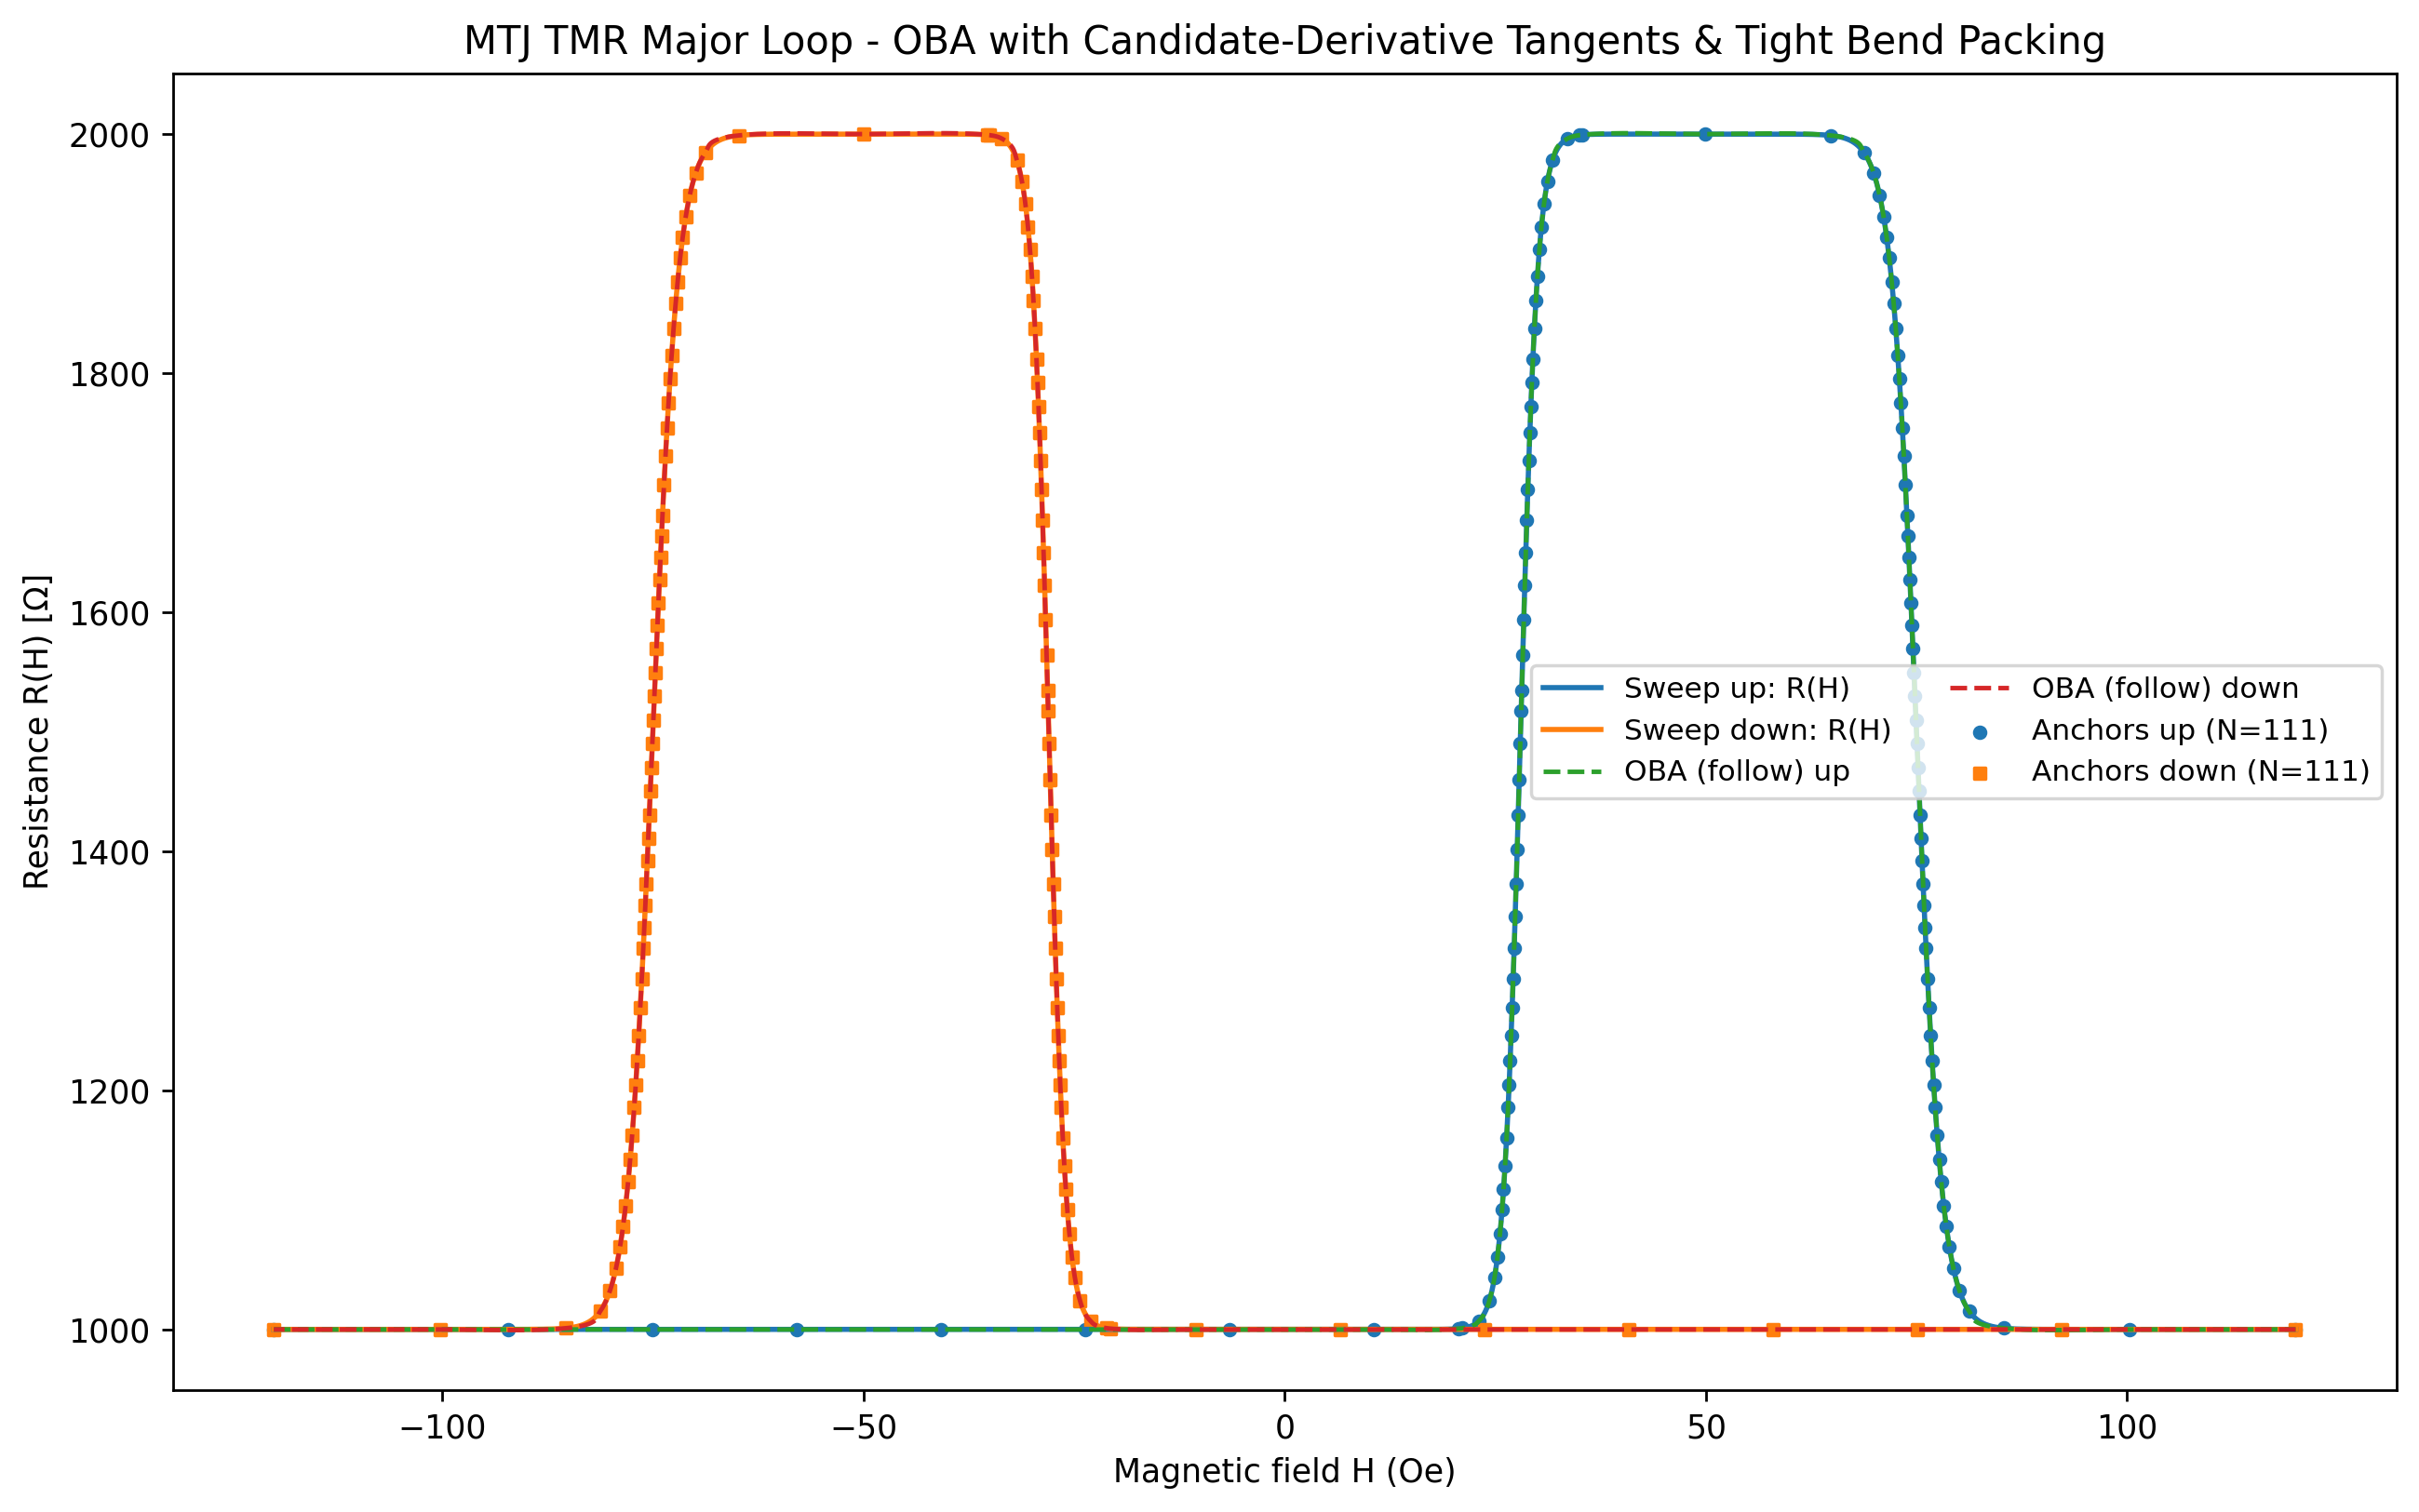

Saved figure to: /content/TMR_OBA_HighResAnchors_FOLLOW.png
Up anchors: 111 Down anchors: 111


In [12]:
# TMR major loop - OBA that follows the interpolated sweep

import os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 250

# ---- NumPy 2.0 deprecation shim (trapz → trapezoid) ----
try:
    _trapz = np.trapezoid   # NumPy >= 2.0
except AttributeError:
    _trapz = np.trapz       # older NumPy

# =========================
# 0) User controls
# =========================
CLUSTER_PERCENTILE: float = 30      # 0–100; higher → cluster only at very sharpest bends
TANGENT_SOURCE: str = "candidate"    # "candidate" | "monotone" | "centripetal"

# Dense candidate + clustering controls
CANDIDATE_OVERSAMPLE: int = 12       # increase to 40–80 in Colab for ultra-tight tracking
MAX_ANCHORS_PER_BRANCH: int = 400    # protective cap (raise if you oversample more)
DENSIFY_ITERS: int = 28              # curvature-mass insertions
DENSIFY_TOP_FRAC: float = 0.95       # fraction of anchors targeted in top-5% curvature
PACKING_SCALE: float = 0.25          # scales local exclusion radius (smaller → more anchors)

def _default_save_path(filename: str) -> str:
    root = "/content" if os.path.isdir("/content") else "/mnt/data"
    return os.path.join(root, filename)

SAVE_PATH = _default_save_path("TMR_OBA_HighResAnchors_FOLLOW.png")

# -----------------------------
# 1) Synthetic CoFeB/MgO-like TMR major loop
# -----------------------------
def _sigma(x: np.ndarray, w: float) -> np.ndarray:
    w = float(max(1e-9, w))
    return 1.0 / (1.0 + np.exp(-x / w))

def major_loop_tmr(
    hmin: float = -120.0,
    hmax: float =  120.0,
    npts: int = 4001,
    hs_soft: float = 28.0,
    hh_hard: float = 75.0,
    width_s: float = 1.0,
    width_h: float = 1.5,
    rp: float = 1000.0,
    tmr_ratio: float = 1.0
):
    h_up = np.linspace(hmin, hmax, int(npts))
    h_dn = np.linspace(hmax, hmin, int(npts))

    # Sweep up: soft flips @ +Hs, hard flips @ +Hh
    m_soft_up = -1.0 + 2.0 * _sigma(h_up - hs_soft, width_s)
    m_hard_up = -1.0 + 2.0 * _sigma(h_up - hh_hard, width_h)

    # Sweep down: hard flips @ -Hh, soft flips @ -Hs
    m_soft_dn =  1.0 - 2.0 * _sigma(-(h_dn + hs_soft), width_s)
    m_hard_dn =  1.0 - 2.0 * _sigma(-(h_dn + hh_hard), width_h)

    rap = rp * (1.0 + float(tmr_ratio))
    def r_from_m(ms, mh):
        # R = RP + (RAP - RP)*(1 - ms*mh)/2
        return rp + (rap - rp) * (1.0 - (ms * mh)) * 0.5

    r_up = r_from_m(m_soft_up, m_hard_up)
    r_dn = r_from_m(m_soft_dn, m_hard_dn)
    return h_up, r_up, h_dn, r_dn

# -----------------------------
# 2) OBA helpers
# -----------------------------
def _smooth_1d(z: np.ndarray, win: int) -> np.ndarray:
    if win <= 1:
        return z.copy()
    k = np.ones(int(win), float) / float(win)
    pad = int(win) // 2
    zp = np.pad(z, (pad, pad), mode="reflect")
    return np.convolve(zp, k, mode="valid")

def _parametric_curvature(sv: np.ndarray, xv: np.ndarray, yv: np.ndarray) -> np.ndarray:
    x_s = np.gradient(xv, sv, edge_order=1)
    y_s = np.gradient(yv, sv, edge_order=1)
    x_ss = np.gradient(x_s, sv, edge_order=1)
    y_ss = np.gradient(y_s, sv, edge_order=1)
    num = np.abs(x_s * y_ss - y_s * x_ss)
    den = (x_s ** 2 + y_s ** 2) ** 1.5 + 1e-12
    return num / den

def _hermite_to_bezier(Pi, Ti, Pj, Tj, si, sj, mseg: int):
    h = sj - si
    c0, c3 = Pi, Pj
    c1 = Pi + (Ti * h / 3.0)
    c2 = Pj - (Tj * h / 3.0)
    t = np.linspace(0.0, 1.0, int(mseg))
    b = ((1 - t)[:, None] ** 3) * c0 + (3 * (1 - t)[:, None] ** 2 * t[:, None]) * c1 \
        + (3 * (1 - t)[:, None] * t[:, None] ** 2) * c2 + (t[:, None] ** 3) * c3
    return b

def _tangents_centripetal(P: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    n = len(P)
    T = np.zeros_like(P, float)
    t = np.zeros(n, float)
    for i in range(1, n):
        t[i] = t[i-1] + np.linalg.norm(P[i] - P[i-1])**alpha
    for i in range(n):
        if i == 0:
            dt = t[1] - t[0] if t[1] > t[0] else 1.0
            T[i] = (P[1] - P[0]) / dt
        elif i == n - 1:
            dt = t[-1] - t[-2] if t[-1] > t[-2] else 1.0
            T[i] = (P[-1] - P[-2]) / dt
        else:
            dt = t[i+1] - t[i-1] if t[i+1] > t[i-1] else 1.0
            T[i] = (P[i+1] - P[i-1]) / dt
    return T

def _tangents_monotone(x: np.ndarray, y: np.ndarray, s_a: np.ndarray) -> np.ndarray:
    n = len(x)
    m = np.zeros(n, float)
    dx = np.diff(x); dy = np.diff(y)
    d = dy / dx
    m[0] = d[0]; m[-1] = d[-1]
    for i in range(1, n-1):
        if d[i-1] * d[i] <= 0:
            m[i] = 0.0
        else:
            w1 = 2*dx[i] + dx[i-1]
            w2 = dx[i] + 2*dx[i-1]
            m[i] = (w1 + w2) / (w1/d[i-1] + w2/d[i])
    ds_dx = np.gradient(s_a, x, edge_order=1)
    return np.stack([ds_dx, m*ds_dx], axis=1)

# ---- PCHIP-like evaluation for y(s), linear x(s) to preserve monotone H ----
def _pchip_slopes(s: np.ndarray, y: np.ndarray) -> np.ndarray:
    s = np.asarray(s, float); y = np.asarray(y, float)
    n = len(s)
    m = np.zeros(n, float)
    ds = np.diff(s); dy = np.diff(y)
    d = dy / ds
    m[0] = d[0]; m[-1] = d[-1]
    for i in range(1, n-1):
        if d[i-1] * d[i] <= 0:
            m[i] = 0.0
        else:
            w1 = 2*ds[i] + ds[i-1]
            w2 = ds[i] + 2*ds[i-1]
            m[i] = (w1 + w2) / (w1/d[i-1] + w2/d[i])
    return m

def _pchip_eval(s: np.ndarray, y: np.ndarray, m: np.ndarray, s_eval: np.ndarray) -> np.ndarray:
    s = np.asarray(s, float); y = np.asarray(y, float); m = np.asarray(m, float)
    s_eval = np.asarray(s_eval, float)
    idx = np.searchsorted(s, s_eval, side="right") - 1
    idx = np.clip(idx, 0, len(s)-2)
    s0 = s[idx]; s1 = s[idx+1]
    y0 = y[idx]; y1 = y[idx+1]
    m0 = m[idx]; m1 = m[idx+1]
    h = (s_eval - s0) / (s1 - s0 + 1e-15)
    h2 = h*h; h3 = h2*h
    H00 = 2*h3 - 3*h2 + 1
    H10 = h3 - 2*h2 + h
    H01 = -2*h3 + 3*h2
    H11 = h3 - h2
    return H00*y0 + H10*(s1 - s0)*m0 + H01*y1 + H11*(s1 - s0)*m1

def _dense_candidate_curve(x: np.ndarray, y: np.ndarray, oversample: int = 40):
    x = np.asarray(x, float); y = np.asarray(y, float)
    dx, dy = np.diff(x), np.diff(y); ds = np.hypot(dx, dy)
    s = np.concatenate([[0.0], np.cumsum(ds)])
    s = np.linspace(0, 1, len(x)) if (s[-1] == 0) else (s / s[-1])
    n = len(s)
    n_f = max(8*n, int(len(s) * oversample))
    s_f = np.linspace(0.0, 1.0, int(n_f))
    x_f = np.interp(s_f, s, x)               # monotone H
    m = _pchip_slopes(s, y)
    y_f = _pchip_eval(s, y, m, s_f)          # smooth R(H)
    return s_f, x_f, y_f

def _tangents_from_candidate(s_f: np.ndarray, x_f: np.ndarray, y_f: np.ndarray, keep_idx: np.ndarray) -> np.ndarray:
    dx_ds = np.gradient(x_f, s_f, edge_order=1)
    dy_ds = np.gradient(y_f, s_f, edge_order=1)
    return np.stack([dx_ds[keep_idx], dy_ds[keep_idx]], axis=1)

# ---- High-resolution OBA fitter (candidate tangents + packing) ----
def _map_percentile_to_hparams(p: float):
    a = float(np.clip(p, 0.0, 100.0)) / 100.0
    return dict(
        r_base=float(np.interp(a, [0, 1], [0.01, 0.08])),
        r_min_floor=float(np.interp(a, [0, 1], [1e-7, 5e-7])),
        r_shrink_max=float(np.interp(a, [0, 1], [0.97, 0.999])),
        r_power=float(np.interp(a, [0, 1], [4.0, 8.0])),
        smooth_window=int(round(np.interp(a, [0, 1], [7, 13]))),
        num_seg_per_bezier=int(round(np.interp(a, [0, 1], [260, 360]))),
    )

def oba_fit_branch_highres_follow(
    x: np.ndarray,
    y: np.ndarray,
    cluster_percentile: float = 10.0,
    tangent_source: str = "candidate",
    oversample: int = 12,
    max_anchors: int = 400,
    densify_iters: int = 28,
    densify_top_frac: float = 0.95,
    packing_scale: float = 0.25,
):
    # Dense candidate curve, independent of raw sampling
    s_f, x_f, y_f = _dense_candidate_curve(x, y, oversample=max(4, int(oversample)))
    hp = _map_percentile_to_hparams(cluster_percentile)

    # Curvature & weight on dense curve
    kappa = _smooth_1d(_parametric_curvature(s_f, x_f, y_f), hp["smooth_window"])
    kappa = np.maximum(kappa, 0.0)
    thr = np.percentile(kappa, float(cluster_percentile))
    kmax = float(kappa.max()) if kappa.size else 1.0
    w = np.clip((kappa - thr) / (kmax - thr + 1e-15), 0.0, 1.0)

    # Pass 1: variable-radius greedy
    r_local = hp["r_base"] * (1.0 - hp["r_shrink_max"] * (w ** hp["r_power"]))
    r_local = np.maximum(r_local, hp["r_min_floor"]) * float(max(1e-6, packing_scale))

    order = np.argsort(-w).astype(int)
    order = order[(order >= 0) & (order < len(s_f))]

    keep = [0, len(s_f)-1]
    kept = np.zeros(len(s_f), bool); kept[0] = kept[-1] = True

    def _too_close(i: int) -> bool:
        for j in np.where(kept)[0]:
            if abs(s_f[i] - s_f[j]) < min(r_local[i], r_local[j]):
                return True
        return False

    for i in order:
        if kept[i]:
            continue
        if not _too_close(i):
            keep.append(i); kept[i] = True
        if len(keep) >= max_anchors:
            break

    keep.sort()
    keep = np.array(keep, int)

    # Pass 2: densify in highest curvature-mass gaps
    target_top = int(densify_top_frac * len(keep))
    for _ in range(int(densify_iters)):
        thr95 = np.percentile(kappa, 95.0)
        n_top = np.count_nonzero(kappa[keep] >= thr95)
        if n_top >= target_top or len(keep) >= max_anchors:
            break
        best_gain = 0.0; best_pos = None; best_insert = None
        for a_idx in range(len(keep)-1):
            i, j = keep[a_idx], keep[a_idx+1]
            if j <= i + 1:
                continue
            window = slice(i+1, j)
            mass = _trapz(w[window], s_f[window])
            if mass > best_gain:
                loc = int(np.argmax(kappa[window])) + (i+1)
                best_gain = mass; best_pos = loc; best_insert = a_idx + 1
        if best_pos is None:
            break
        pos = int(best_pos)
        if pos < 0 or pos >= len(s_f):
            continue
        if not _too_close(pos):
            keep = np.insert(keep, best_insert, pos)

    # Anchors from dense curve
    s_a = s_f[keep]
    P_a = np.stack([x_f[keep], y_f[keep]], axis=1)

    # Tangents: from candidate derivatives, or fallback
    if tangent_source == "candidate":
        T = _tangents_from_candidate(s_f, x_f, y_f, keep)
    elif tangent_source == "monotone":
        T = _tangents_monotone(P_a[:,0], P_a[:,1], s_a)
    else:
        T = _tangents_centripetal(P_a, alpha=0.5)

    # Build composite Bézier from anchors
    seg_pts = []
    for i in range(len(s_a)-1):
        seg = _hermite_to_bezier(P_a[i], T[i], P_a[i+1], T[i+1],
                                 s_a[i], s_a[i+1], hp["num_seg_per_bezier"])
        if i > 0: seg = seg[1:]
        seg_pts.append(seg)
    seg_pts = np.vstack(seg_pts) if seg_pts else P_a.copy()
    return seg_pts[:,0], seg_pts[:,1], P_a, keep, kappa, s_f, hp

# -----------------------------
# 3) Generate, fit, and plot
# -----------------------------
H_UP, R_UP, H_DN, R_DN = major_loop_tmr()

bx_up, by_up, anchors_up, idx_up, kappa_up, s_up, hp_up = oba_fit_branch_highres_follow(
    H_UP, R_UP,
    cluster_percentile=CLUSTER_PERCENTILE,
    tangent_source=TANGENT_SOURCE,
    oversample=CANDIDATE_OVERSAMPLE,
    max_anchors=MAX_ANCHORS_PER_BRANCH,
    densify_iters=DENSIFY_ITERS,
    densify_top_frac=DENSIFY_TOP_FRAC,
    packing_scale=PACKING_SCALE,
)
bx_dn, by_dn, anchors_dn, idx_dn, kappa_dn, s_dn, hp_dn = oba_fit_branch_highres_follow(
    H_DN, R_DN,
    cluster_percentile=CLUSTER_PERCENTILE,
    tangent_source=TANGENT_SOURCE,
    oversample=CANDIDATE_OVERSAMPLE,
    max_anchors=MAX_ANCHORS_PER_BRANCH,
    densify_iters=DENSIFY_ITERS,
    densify_top_frac=DENSIFY_TOP_FRAC,
    packing_scale=PACKING_SCALE,
)

plt.figure(figsize=(10.5, 6.6))
plt.plot(H_UP, R_UP, linewidth=1.6, label="Sweep up: R(H)")
plt.plot(H_DN, R_DN, linewidth=1.6, label="Sweep down: R(H)")
plt.plot(bx_up, by_up, linestyle="--", linewidth=1.4, label="OBA (follow) up")
plt.plot(bx_dn, by_dn, linestyle="--", linewidth=1.4, label="OBA (follow) down")
plt.scatter(anchors_up[:,0], anchors_up[:,1], s=12, marker="o", label=f"Anchors up (N={len(anchors_up)})")
plt.scatter(anchors_dn[:,0], anchors_dn[:,1], s=12, marker="s", label=f"Anchors down (N={len(anchors_dn)})")
plt.xlabel("Magnetic field H (Oe)")
plt.ylabel("Resistance R(H) [Ω]")
plt.title("MTJ TMR Major Loop - OBA with Candidate-Derivative Tangents & Tight Bend Packing")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=220)
plt.show()

print("Saved figure to:", SAVE_PATH)
print("Up anchors:", len(anchors_up), "Down anchors:", len(anchors_dn))

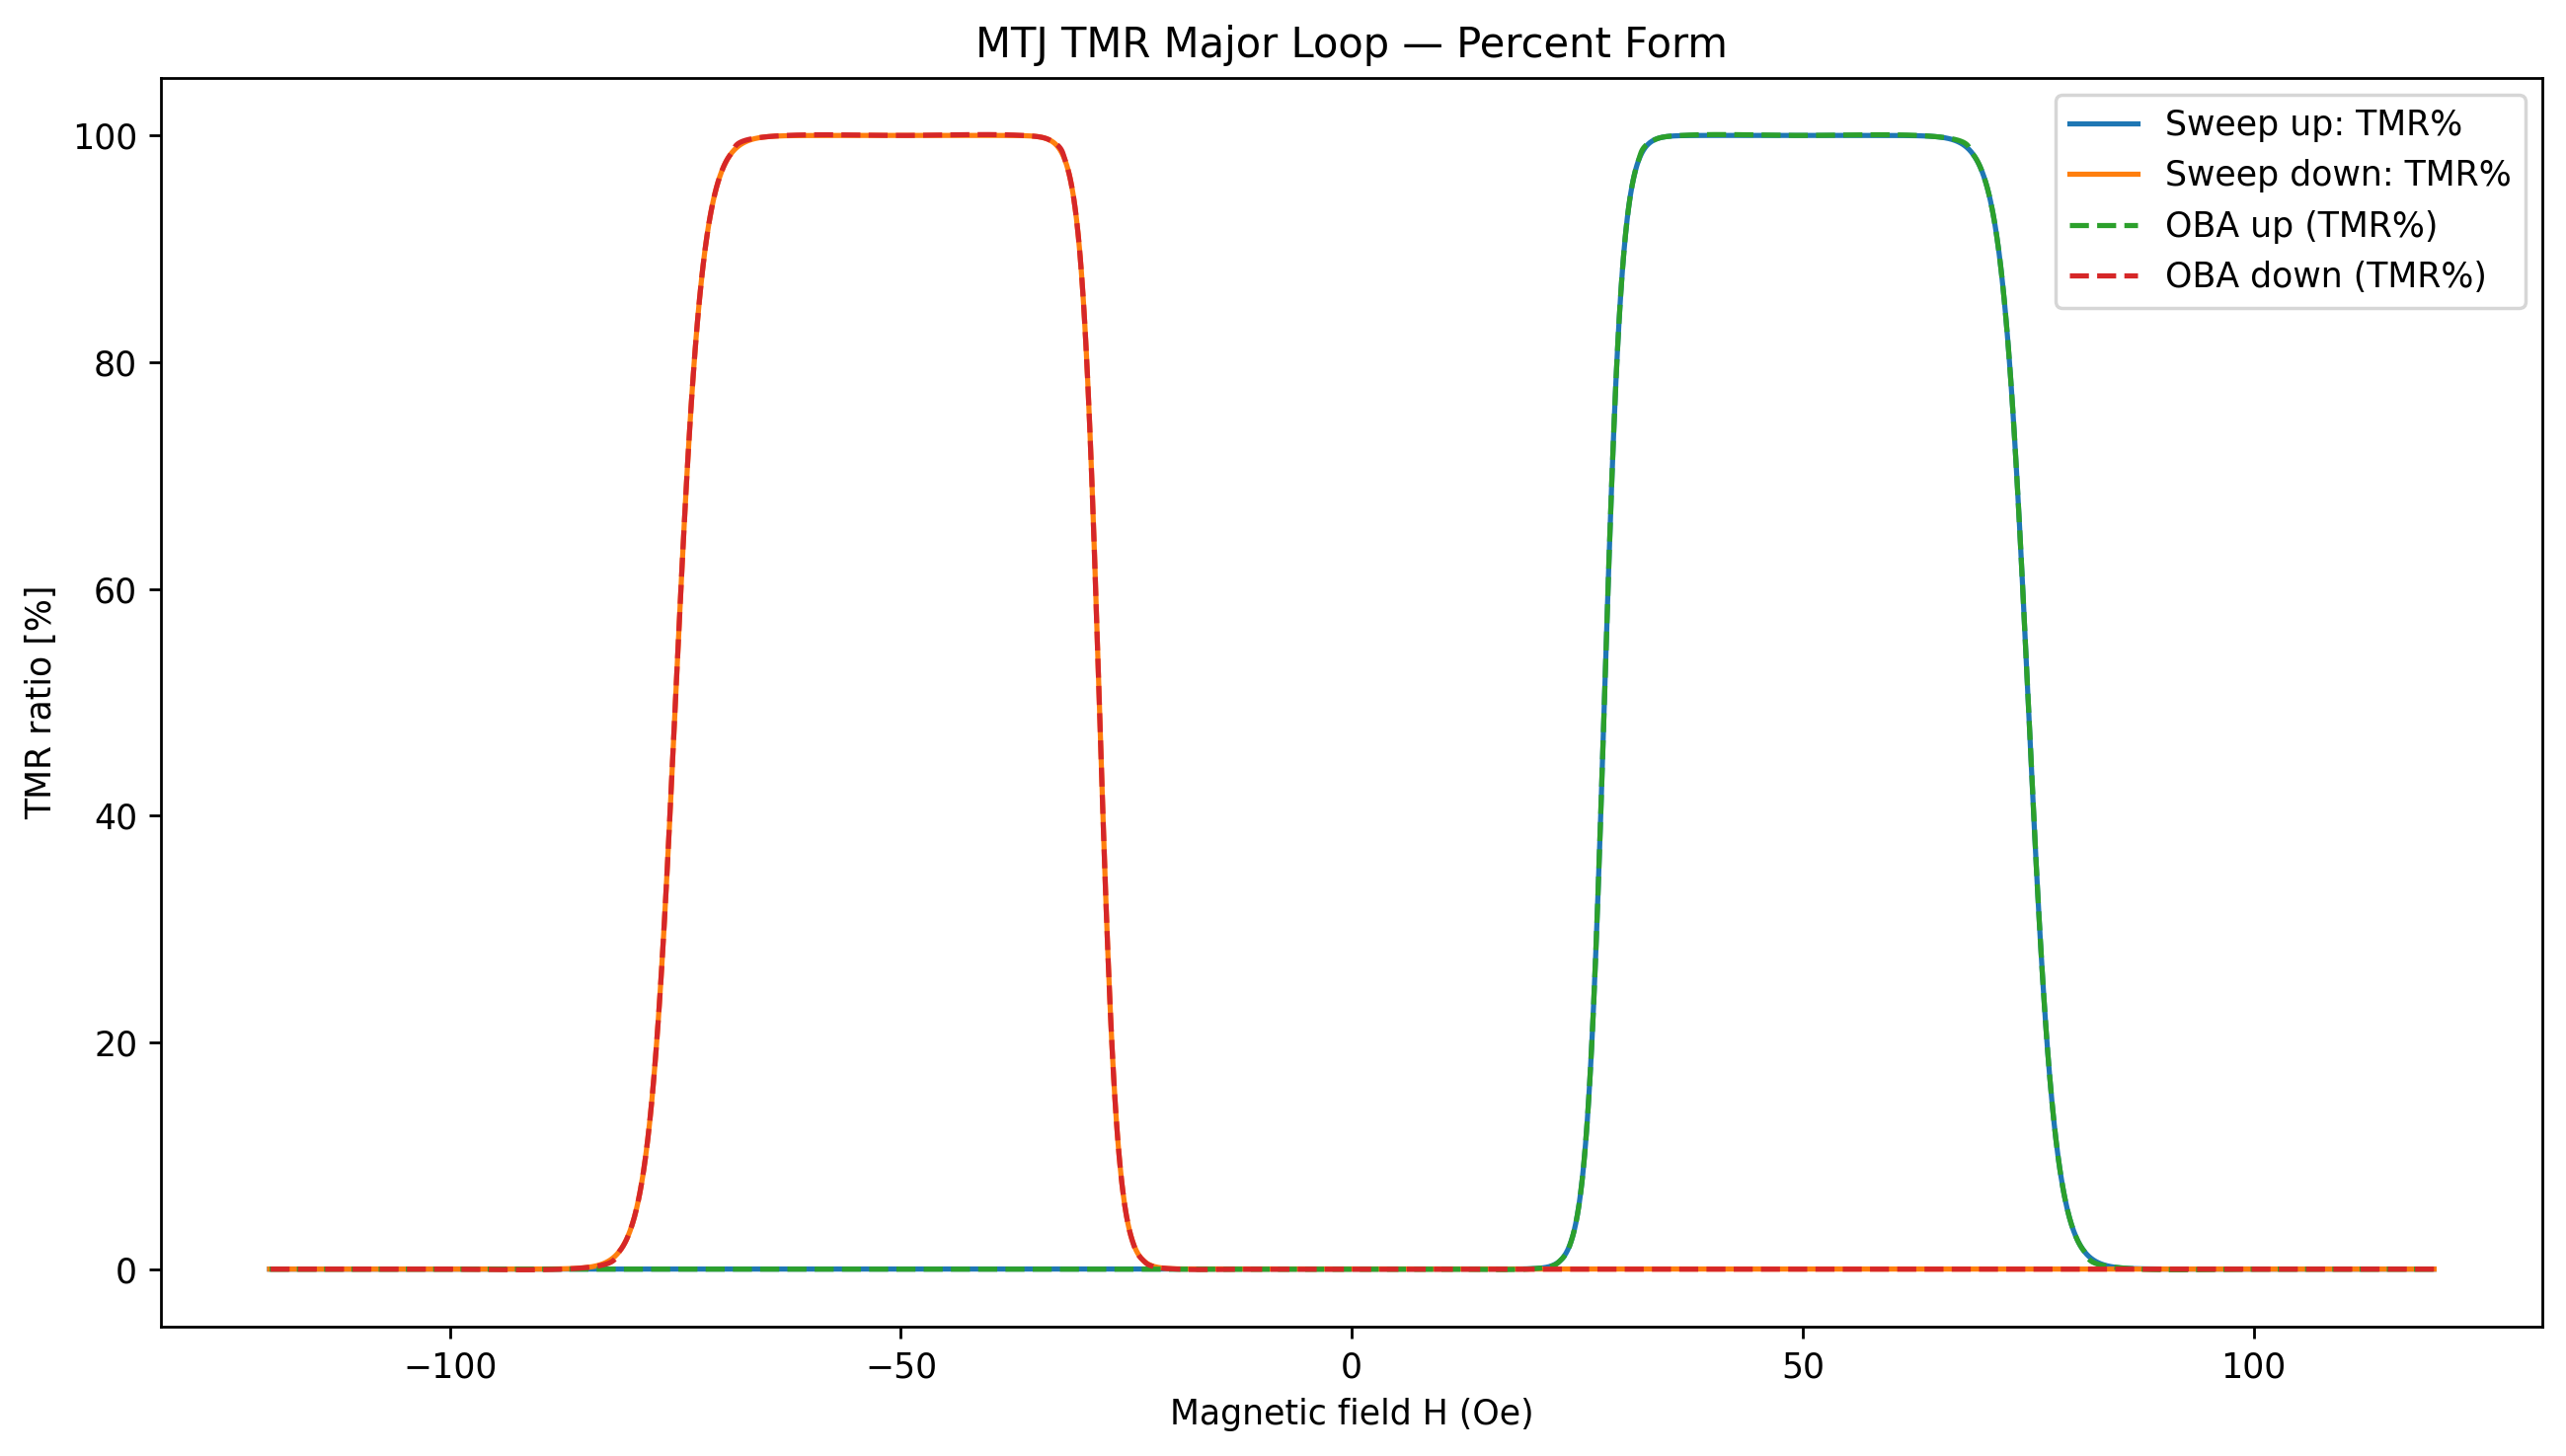

In [13]:
# TMR ratio using the same threshold amount set in the previous code cell
def tmr_percent(r, rp=1000.0):
    return 100.0 * (r - rp) / rp

plt.figure(figsize=(10.5, 6.0))
plt.plot(H_UP, tmr_percent(R_UP), label="Sweep up: TMR%")
plt.plot(H_DN, tmr_percent(R_DN), label="Sweep down: TMR%")
plt.plot(bx_up, tmr_percent(by_up), "--", label="OBA up (TMR%)")
plt.plot(bx_dn, tmr_percent(by_dn), "--", label="OBA down (TMR%)")
plt.xlabel("Magnetic field H (Oe)")
plt.ylabel("TMR ratio [%]")
plt.title("MTJ TMR Major Loop - Percent Form")
plt.legend(); plt.tight_layout()